In [19]:
from google.colab import drive
drive.mount('/content/drive/')
import os

os.chdir('/content/drive/MyDrive/makkook')
!ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
data_set1  data_set2  sam_vit_h_4b8939.pth


In [20]:
!pip install rasterio
!pip install ultralytics

In [21]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import cv2
from PIL import Image
import pandas as pd
from pathlib import Path
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from skimage import filters, segmentation, measure, morphology
from skimage.feature import canny, corner_harris, corner_peaks
from scipy import ndimage
import warnings
warnings.filterwarnings('ignore')

from __future__ import annotations

import argparse
import json
import os
from pathlib import Path

import cv2
import numpy as np
import rasterio
from rasterio.windows import Window
from tqdm import tqdm

# try:
#     from rpcm.rpc_model import RPCModel  # lightweight pixel↔geo helper
# except ImportError:
#     RPCModel = None  # geolocation will be disabled

# Ultralytics YOLOv8 (pip install ultralytics)

# Set visualization parameters
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully")


Libraries imported successfully


In [22]:
# Define file paths and verify data
mss_path = Path("data_set1/JL1KF01C_PMSR2_20240428161912_200258391_103_0008_001_L1_MSS_598095.tif")
pan_path = Path("data_set2/JL1KF01C_PMSR2_20240428161912_200258391_103_0008_001_L1_PAN_598095.tif")

# Verify files exist
print(f"MSS file exists: {mss_path.exists()}")
if mss_path.exists():
    print(f"MSS file size: {mss_path.stat().st_size / (1024**2):.1f} MB")

print(f"PAN file exists: {pan_path.exists()}")
if pan_path.exists():
    print(f"PAN file size: {pan_path.stat().st_size / (1024**2):.1f} MB")


MSS file exists: True
MSS file size: 169.1 MB
PAN file exists: True
PAN file size: 676.8 MB


In [23]:
def load_and_analyze_image(file_path, image_type, sample_size=2000):
    """Load image and extract comprehensive metadata"""
    if not file_path.exists():
        print(f"File not found: {file_path}")
        return None, None

    with rasterio.open(file_path) as src:
        # Get metadata
        meta = {
            'width': src.width,
            'height': src.height,
            'bands': src.count,
            'dtype': src.dtypes[0],
            'crs': src.crs,
            'bounds': src.bounds,
            'transform': src.transform,
            'resolution': src.res
        }

        print(f"\n{image_type} Image Analysis:")
        print(f"Dimensions: {meta['width']} x {meta['height']} pixels")
        print(f"Bands: {meta['bands']}")
        print(f"Data type: {meta['dtype']}")
        print(f"Resolution: {meta['resolution'][0]:.2f} x {meta['resolution'][1]:.2f} units")
        print(f"Total pixels: {meta['width'] * meta['height']:,}")

        # Calculate ground sample distance
        if meta['resolution'][0] > 0:
            print(f"Ground Sample Distance: ~{meta['resolution'][0]:.1f} meters")

        # Load a sample of the data for analysis
        center_x, center_y = meta['width'] // 2, meta['height'] // 2
        sample_size = min(sample_size, meta['width'], meta['height'])

        window = rasterio.windows.Window(
            center_x - sample_size//2, center_y - sample_size//2,
            sample_size, sample_size
        )

        # Read sample data
        sample_data = src.read(window=window)
        print(f"Sample loaded: {sample_data.shape} (center {sample_size}x{sample_size} pixels)")

        return meta, sample_data

# Load both images
print("Loading satellite imagery data...")
mss_meta, mss_sample = load_and_analyze_image(mss_path, "Multispectral (MSS)")
pan_meta, pan_sample = load_and_analyze_image(pan_path, "Panchromatic (PAN)")


Loading satellite imagery data...

Multispectral (MSS) Image Analysis:
Dimensions: 4086 x 5422 pixels
Bands: 4
Data type: uint16
Resolution: 1.00 x 1.00 units
Total pixels: 22,154,292
Ground Sample Distance: ~1.0 meters
Sample loaded: (4, 2000, 2000) (center 2000x2000 pixels)

Panchromatic (PAN) Image Analysis:
Dimensions: 16341 x 21710 pixels
Bands: 1
Data type: uint16
Resolution: 1.00 x 1.00 units
Total pixels: 354,763,110
Ground Sample Distance: ~1.0 meters
Sample loaded: (1, 2000, 2000) (center 2000x2000 pixels)


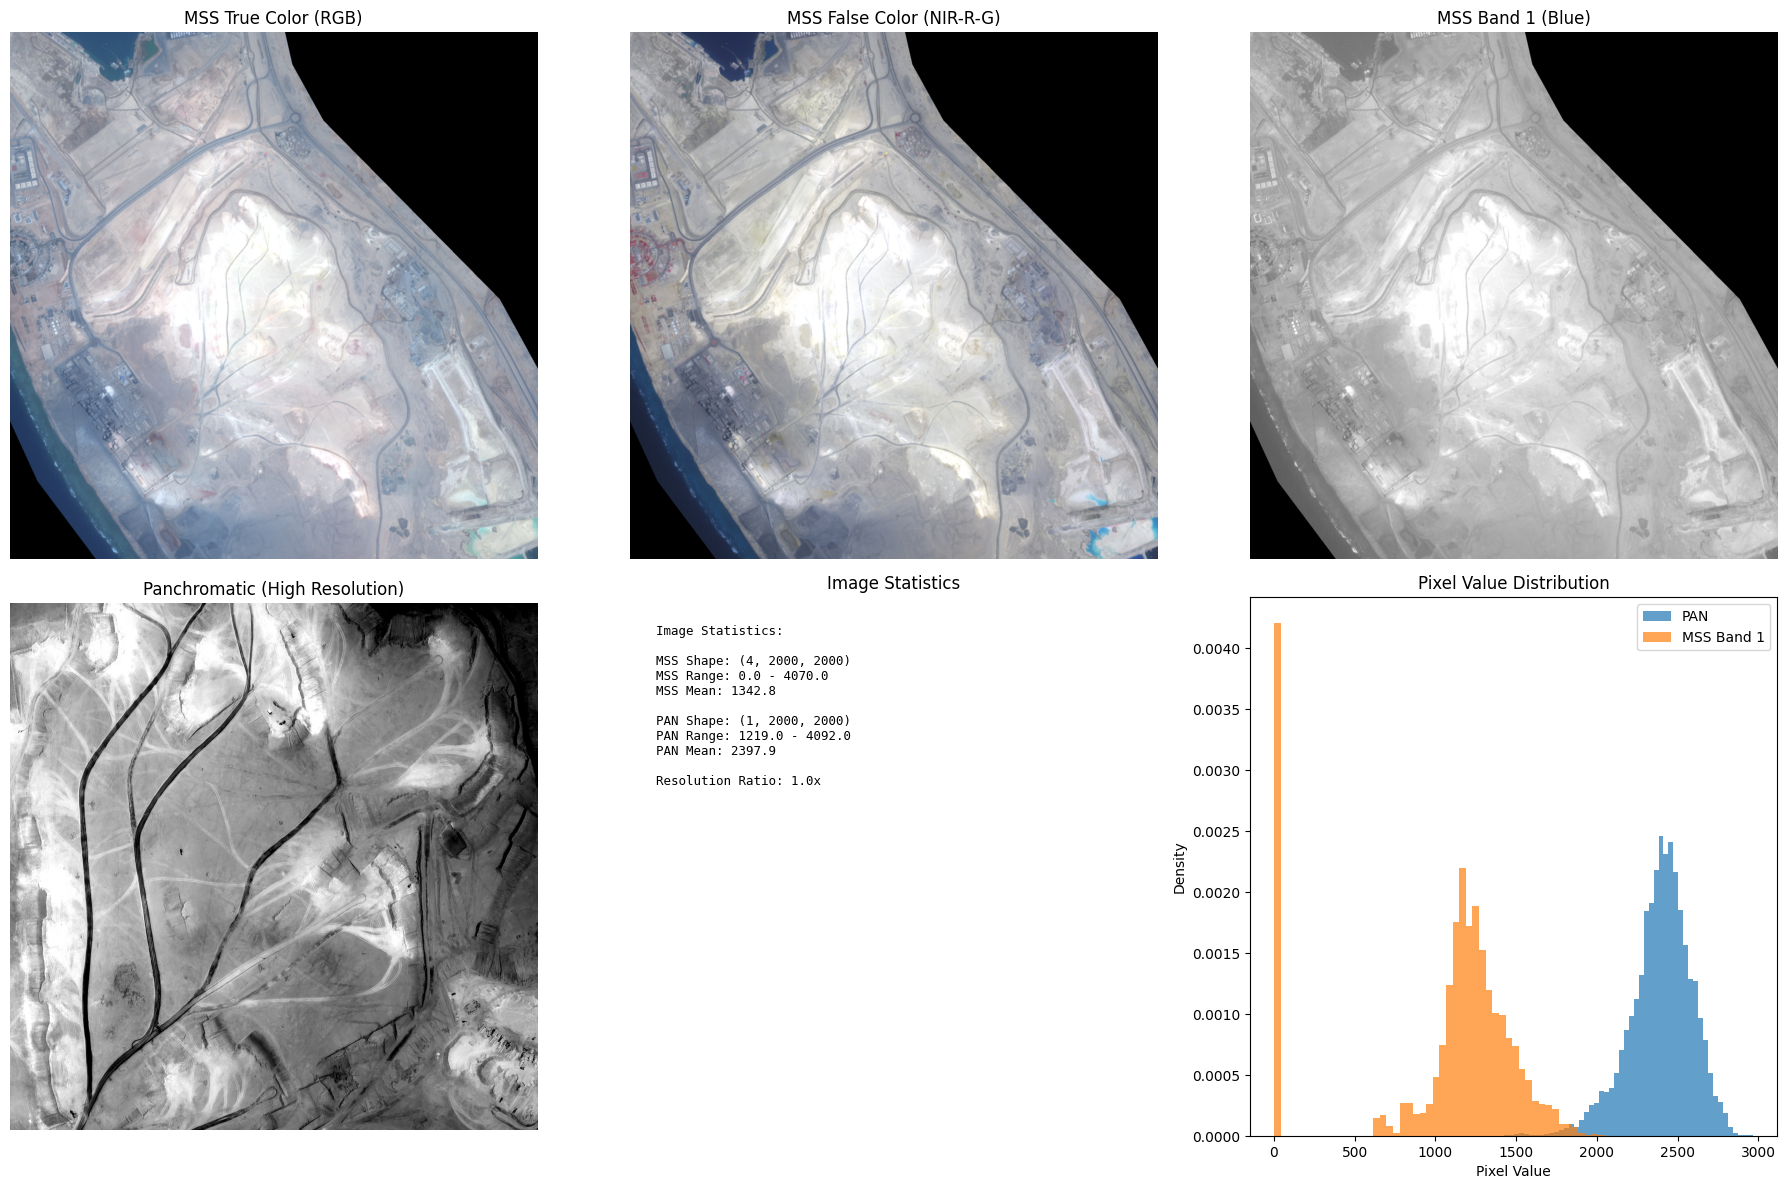

Image preprocessing and visualization complete


In [24]:
def scale_to_8bit(arr, p_low=2, p_high=98):
    """Scale array to 8-bit using percentile stretching"""
    if arr is None or arr.size == 0:
        return np.zeros((100, 100), dtype=np.uint8)

    valid = arr[np.isfinite(arr)]
    if valid.size == 0:
        return np.zeros_like(arr, dtype=np.uint8)

    low, high = np.percentile(valid, (p_low, p_high))
    if low == high:
        high = low + 1

    scaled = np.clip((arr - low) * 255.0 / (high - low), 0, 255)
    return scaled.astype(np.uint8)

def create_rgb_composite(mss_data, rgb_bands=(2, 1, 0)):
    """Create RGB composite from multispectral data"""
    if mss_data is None or mss_data.shape[0] < 3:
        print("⚠️ Insufficient bands for RGB composite")
        return np.zeros((100, 100, 3), dtype=np.uint8)

    rgb_arrays = []
    for band_idx in rgb_bands:
        if band_idx < mss_data.shape[0]:
            band_data = mss_data[band_idx].astype(np.float32)
            rgb_arrays.append(scale_to_8bit(band_data))
        else:
            rgb_arrays.append(np.zeros_like(mss_data[0], dtype=np.uint8))

    return np.stack(rgb_arrays, axis=2)

# Create comprehensive visualizations
if mss_sample is not None and pan_sample is not None:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # MSS RGB composite (True Color: Red, Green, Blue)
    mss_rgb = create_rgb_composite(mss_sample, (2, 1, 0))  # R,G,B
    axes[0,0].imshow(mss_rgb)
    axes[0,0].set_title('MSS True Color (RGB)')
    axes[0,0].axis('off')

    # MSS False color composite (NIR, Red, Green)
    if mss_sample.shape[0] >= 4:
        mss_false = create_rgb_composite(mss_sample, (3, 2, 1))  # NIR,R,G
        axes[0,1].imshow(mss_false)
        axes[0,1].set_title('MSS False Color (NIR-R-G)')
        axes[0,1].axis('off')
    else:
        axes[0,1].text(0.5, 0.5, 'Insufficient bands\nfor false color',
                       ha='center', va='center', transform=axes[0,1].transAxes)
        axes[0,1].set_title('MSS False Color (Unavailable)')
        axes[0,1].axis('off')

    # Individual MSS band
    if mss_sample.shape[0] > 0:
        axes[0,2].imshow(scale_to_8bit(mss_sample[0]), cmap='gray')
        axes[0,2].set_title('MSS Band 1 (Blue)')
        axes[0,2].axis('off')

    # Panchromatic image
    pan_scaled = scale_to_8bit(pan_sample[0])
    axes[1,0].imshow(pan_scaled, cmap='gray')
    axes[1,0].set_title('Panchromatic (High Resolution)')
    axes[1,0].axis('off')

    # Statistics comparison
    stats_text = f"""Image Statistics:

MSS Shape: {mss_sample.shape}
MSS Range: {mss_sample.min():.1f} - {mss_sample.max():.1f}
MSS Mean: {mss_sample.mean():.1f}

PAN Shape: {pan_sample.shape}
PAN Range: {pan_sample.min():.1f} - {pan_sample.max():.1f}
PAN Mean: {pan_sample.mean():.1f}

Resolution Ratio: {pan_sample.shape[1] / mss_sample.shape[1]:.1f}x"""

    axes[1,1].text(0.05, 0.95, stats_text, transform=axes[1,1].transAxes,
                   fontsize=9, verticalalignment='top', fontfamily='monospace')
    axes[1,1].set_title('Image Statistics')
    axes[1,1].axis('off')

    # Histogram comparison
    pan_hist = pan_sample[0].flatten()[::100]  # Sample for speed
    mss_hist = mss_sample[0].flatten()[::100]

    axes[1,2].hist(pan_hist, bins=50, alpha=0.7, label='PAN', density=True)
    axes[1,2].hist(mss_hist, bins=50, alpha=0.7, label='MSS Band 1', density=True)
    axes[1,2].set_title('Pixel Value Distribution')
    axes[1,2].set_xlabel('Pixel Value')
    axes[1,2].set_ylabel('Density')
    axes[1,2].legend()

    plt.tight_layout()
    plt.show()

    print("Image preprocessing and visualization complete")
else:
    print("Unable to load image data for visualization")



🛣️ Detecting potential road features...
Found 4553 potential line segments.
✅ Road feature detection complete


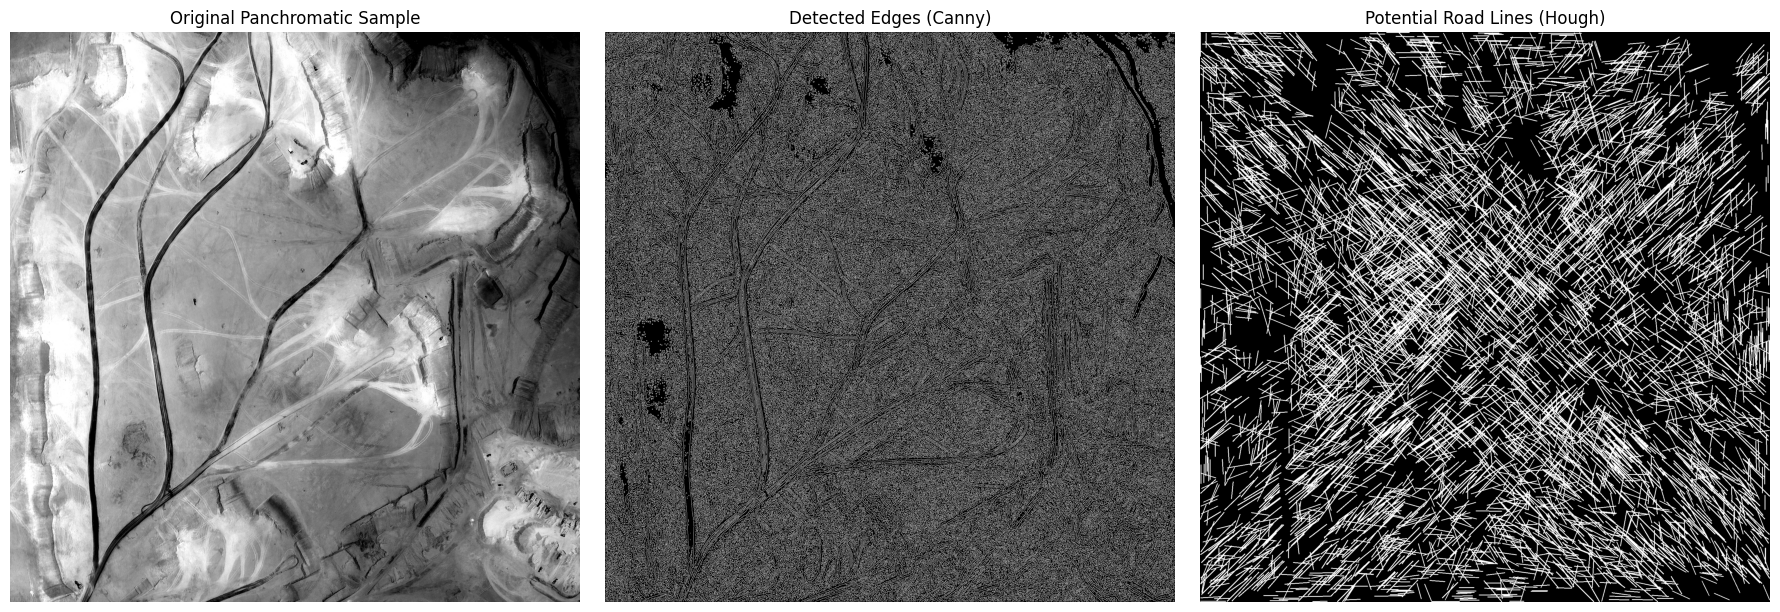


ℹ️ Interpretation:
- The 'Detected Edges' image shows areas of sharp intensity changes, which could be road boundaries.
- The 'Potential Road Lines' image highlights straight line segments detected from the edges.
  Keep in mind this is a basic approach; it will also detect other linear features like buildings, field boundaries, etc.
  More advanced techniques (e.g., machine learning models) would be needed for accurate road segmentation.


In [25]:
# %%
def detect_roads_pan(pan_data, sigma=1.0, low_threshold=0.05, high_threshold=0.15, min_line_length=50, max_line_gap=5):
    """
    Detect potential road features in panchromatic imagery using edge and line detection.

    Args:
        pan_data (np.ndarray): The panchromatic image data (single band).
        sigma (float): Sigma for the Canny edge detector Gaussian filter.
        low_threshold (float): Lower hysteresis threshold for Canny.
        high_threshold (float): Upper hysteresis threshold for Canny.
        min_line_length (int): Minimum length of a line to be accepted by HoughLinesP.
        max_line_gap (int): Maximum allowed gap between line segments to join them by HoughLinesP.

    Returns:
        tuple: A tuple containing the edge-detected image and an image with detected lines drawn.
               Returns (None, None) if pan_data is None or empty.
    """
    if pan_data is None or pan_data.size == 0:
        print("⚠️ No panchromatic data available for road detection.")
        return None, None

    print("\n🛣️ Detecting potential road features...")

    # Ensure data is in a suitable format (e.g., uint8)
    # Scale to 8-bit if it's not already, using the function defined earlier
    pan_scaled = scale_to_8bit(pan_data[0])

    # Apply Canny edge detection
    # Canny is good for finding intensity gradients, which often occur at road edges
    edges = canny(pan_scaled, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)

    # Use Hough Line Transform to find lines in the edge-detected image
    # Probabilistic Hough Transform (HoughLinesP) is generally better for detecting finite lines
    lines_image = np.zeros_like(pan_scaled, dtype=np.uint8)
    lines = cv2.HoughLinesP(edges.astype(np.uint8), rho=1, theta=np.pi/180, threshold=50,
                            minLineLength=min_line_length, maxLineGap=max_line_gap)

    if lines is not None:
        print(f"Found {len(lines)} potential line segments.")
        # Draw detected lines on a blank image
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(lines_image, (x1, y1), (x2, y2), 255, 2) # Draw in white

    print("✅ Road feature detection complete")
    return edges, lines_image

# Perform road detection using the panchromatic sample data
if pan_sample is not None:
    road_edges, detected_lines = detect_roads_pan(pan_sample)

    # Visualize the results
    if road_edges is not None and detected_lines is not None:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # Display the original panchromatic sample
        axes[0].imshow(scale_to_8bit(pan_sample[0]), cmap='gray')
        axes[0].set_title('Original Panchromatic Sample')
        axes[0].axis('off')

        # Display the detected edges
        axes[1].imshow(road_edges, cmap='gray')
        axes[1].set_title('Detected Edges (Canny)')
        axes[1].axis('off')

        # Display the detected lines
        axes[2].imshow(detected_lines, cmap='gray')
        axes[2].set_title('Potential Road Lines (Hough)')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

        print("\nℹ️ Interpretation:")
        print("- The 'Detected Edges' image shows areas of sharp intensity changes, which could be road boundaries.")
        print("- The 'Potential Road Lines' image highlights straight line segments detected from the edges.")
        print("  Keep in mind this is a basic approach; it will also detect other linear features like buildings, field boundaries, etc.")
        print("  More advanced techniques (e.g., machine learning models) would be needed for accurate road segmentation.")
else:
    print("❌ Panchromatic sample data not available to perform road detection.")


🔬 Calculating spectral indices (NDVI, NDWI)...
✅ Spectral index calculation complete

🗺️ Creating vegetation mask with threshold 0.40...
✅ Vegetation mask created. Pixel count: 174

🗺️ Creating water mask with threshold 0.00...
✅ Water mask created. Pixel count: 159,034


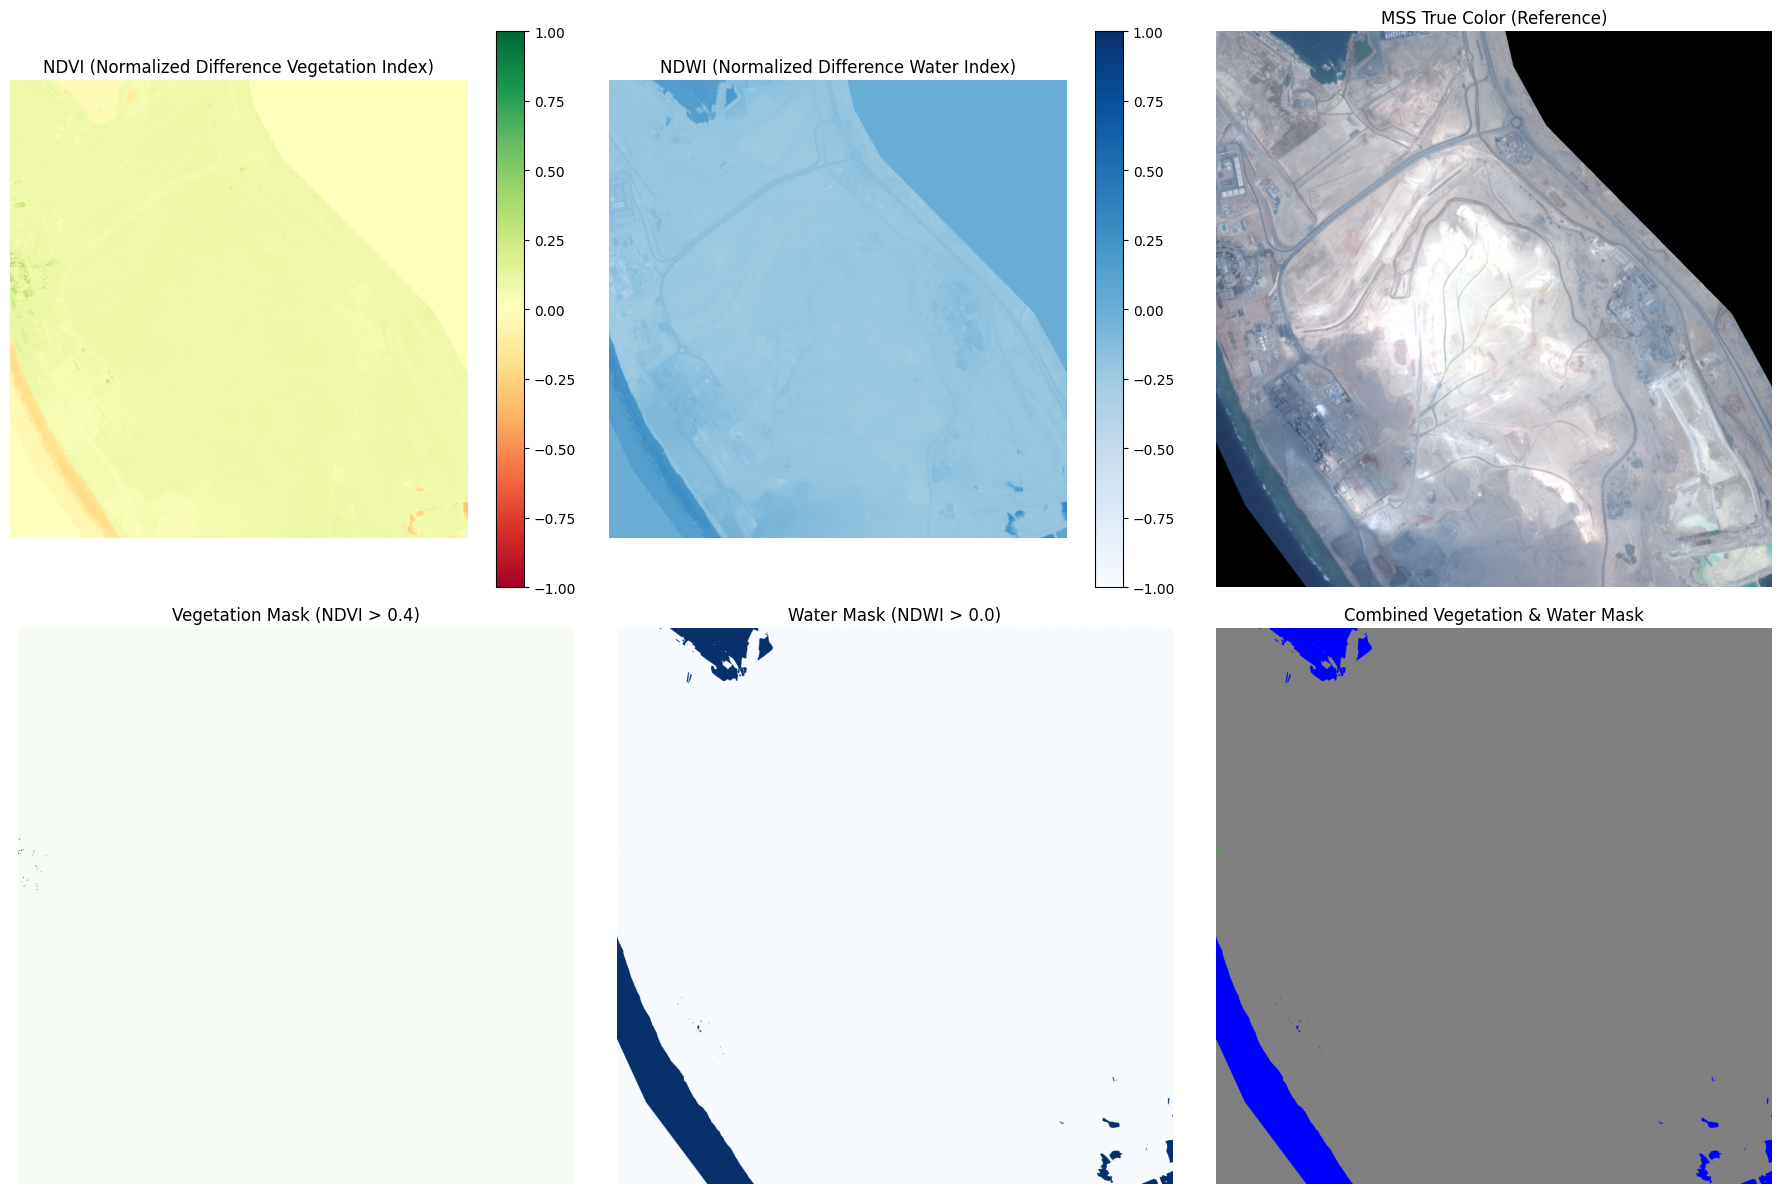

Spectral indices and land-cover masks visualized.


In [26]:

import matplotlib.pyplot as plt
import numpy as np
def calculate_spectral_indices(mss_data):
    """
    Calculate NDVI (Normalized Difference Vegetation Index) and
    NDWI (Normalized Difference Water Index) from MSS data.
    Assumes bands are in order: Blue, Green, Red, NIR (Indices 0, 1, 2, 3)
    """
    if mss_data is None or mss_data.shape[0] < 4:
        print("⚠️ Insufficient bands for NDVI/NDWI calculation (requires Blue, Green, Red, NIR).")
        return None, None

    print("\n🔬 Calculating spectral indices (NDVI, NDWI)...")

    # Extract relevant bands, handle potential division by zero
    red = mss_data[2].astype(np.float32)  # Red band
    nir = mss_data[3].astype(np.float32)  # NIR band
    green = mss_data[1].astype(np.float32) # Green band

    # Calculate NDVI: (NIR - Red) / (NIR + Red)
    # Add a small epsilon to the denominator to avoid division by zero
    ndvi = np.where(
        (nir + red) == 0.,
        0,  # Set to 0 where sum is zero
        (nir - red) / (nir + red)
    )
    ndvi = np.nan_to_num(ndvi, nan=0.0) # Replace potential NaNs with 0

    # Calculate NDWI: (Green - NIR) / (Green + NIR)
    # Add a small epsilon to the denominator to avoid division by zero
    ndwi = np.where(
         (green + nir) == 0.,
         0, # Set to 0 where sum is zero
         (green - nir) / (green + nir)
    )
    ndwi = np.nan_to_num(ndwi, nan=0.0) # Replace potential NaNs with 0

    print("✅ Spectral index calculation complete")
    return ndvi, ndwi

def create_land_cover_mask(spectral_index, threshold, mask_type="vegetation"):
    """
    Create a binary mask based on a spectral index threshold.
    """
    if spectral_index is None:
        print(f"⚠️ Cannot create mask, spectral index data is None.")
        return None

    print(f"\n🗺️ Creating {mask_type} mask with threshold {threshold:.2f}...")

    if mask_type == "vegetation":
        mask = spectral_index > threshold
    elif mask_type == "water":
        mask = spectral_index > threshold # NDWI uses a positive threshold for water
    else:
        print(f"⚠️ Unknown mask type: {mask_type}. Supported: 'vegetation', 'water'.")
        return None

    print(f"✅ {mask_type.capitalize()} mask created. Pixel count: {np.sum(mask):,}")
    return mask

# Calculate NDVI and NDWI
ndvi, ndwi = calculate_spectral_indices(mss_sample)

# Create land cover masks using example thresholds
# These thresholds are typical but may need tuning based on imagery characteristics
vegetation_mask = create_land_cover_mask(ndvi, threshold=0.4, mask_type="vegetation")
water_mask = create_land_cover_mask(ndwi, threshold=0.0, mask_type="water")

# Visualize the spectral indices and masks
if ndvi is not None and ndwi is not None:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Display NDVI
    im1 = axes[0, 0].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1) # Red-Yellow-Green colormap is common for NDVI
    axes[0, 0].set_title('NDVI (Normalized Difference Vegetation Index)')
    axes[0, 0].axis('off')
    fig.colorbar(im1, ax=axes[0, 0])

    # Display NDWI
    im2 = axes[0, 1].imshow(ndwi, cmap='Blues', vmin=-1, vmax=1) # Blues colormap is intuitive for water
    axes[0, 1].set_title('NDWI (Normalized Difference Water Index)')
    axes[0, 1].axis('off')
    fig.colorbar(im2, ax=axes[0, 1])

    # Display MSS True Color for reference
    mss_rgb = create_rgb_composite(mss_sample, (2, 1, 0))
    axes[0, 2].imshow(mss_rgb)
    axes[0, 2].set_title('MSS True Color (Reference)')
    axes[0, 2].axis('off')

    # Display Vegetation Mask
    if vegetation_mask is not None:
        axes[1, 0].imshow(vegetation_mask, cmap='Greens') # Binary mask - green for vegetation
        axes[1, 0].set_title(f'Vegetation Mask (NDVI > {0.4})')
        axes[1, 0].axis('off')
    else:
        axes[1, 0].text(0.5, 0.5, 'Vegetation mask\nunavailable', ha='center', va='center', transform=axes[1,0].transAxes)
        axes[1, 0].set_title('Vegetation Mask (Unavailable)')
        axes[1, 0].axis('off')


    # Display Water Mask
    if water_mask is not None:
        axes[1, 1].imshow(water_mask, cmap='Blues') # Binary mask - blue for water
        axes[1, 1].set_title(f'Water Mask (NDWI > {0.0})')
        axes[1, 1].axis('off')
    else:
        axes[1, 1].text(0.5, 0.5, 'Water mask\nunavailable', ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1, 1].set_title('Water Mask (Unavailable)')
        axes[1, 1].axis('off')

    # Display a combined mask (optional)
    if vegetation_mask is not None and water_mask is not None:
        # Create an image where vegetation is green, water is blue, and others are gray
        combined_mask_display = np.zeros((*vegetation_mask.shape, 3), dtype=np.uint8)
        combined_mask_display[vegetation_mask] = [0, 255, 0] # Green for vegetation
        combined_mask_display[water_mask] = [0, 0, 255] # Blue for water

        # Add a gray background for areas that are neither
        neither_mask = ~(vegetation_mask | water_mask)
        combined_mask_display[neither_mask] = [128, 128, 128] # Gray

        axes[1, 2].imshow(combined_mask_display)
        axes[1, 2].set_title('Combined Vegetation & Water Mask')
        axes[1, 2].axis('off')
    else:
        axes[1, 2].text(0.5, 0.5, 'Combined mask\nunavailable', ha='center', va='center', transform=axes[1,2].transAxes)
        axes[1, 2].set_title('Combined Mask (Unavailable)')
        axes[1, 2].axis('off')


    plt.tight_layout()
    plt.show()

    print("Spectral indices and land-cover masks visualized.")

else:
    print("Unable to calculate spectral indices or create masks due to missing data.")


vigitation is very low already


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-lqhdl2w4
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-lqhdl2w4
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
Using device: cpu
SAM model loaded successfully.

Attempting SAM masking using a single point...

🪄 Applying SAM masking...
✅ SAM masking complete
SAM predicted 1 mask(s) from point input.


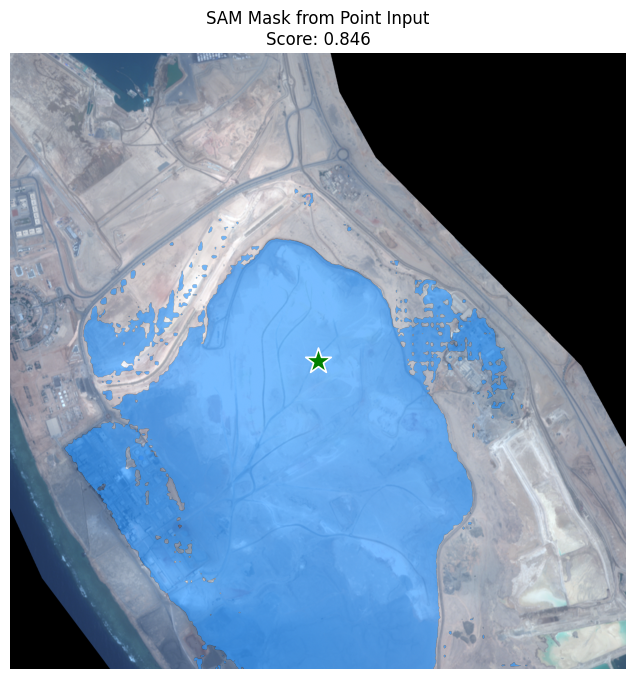


Attempting SAM masking using a bounding box...

🪄 Applying SAM masking...
✅ SAM masking complete
SAM predicted 1 mask(s) from box input.


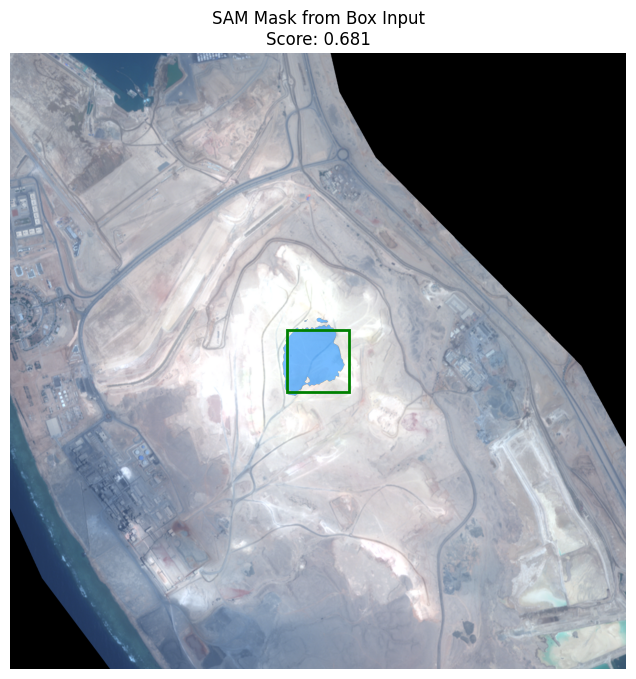


Attempting SAM masking using combined point and box...

🪄 Applying SAM masking...
✅ SAM masking complete
SAM predicted 1 mask(s) from combined input.


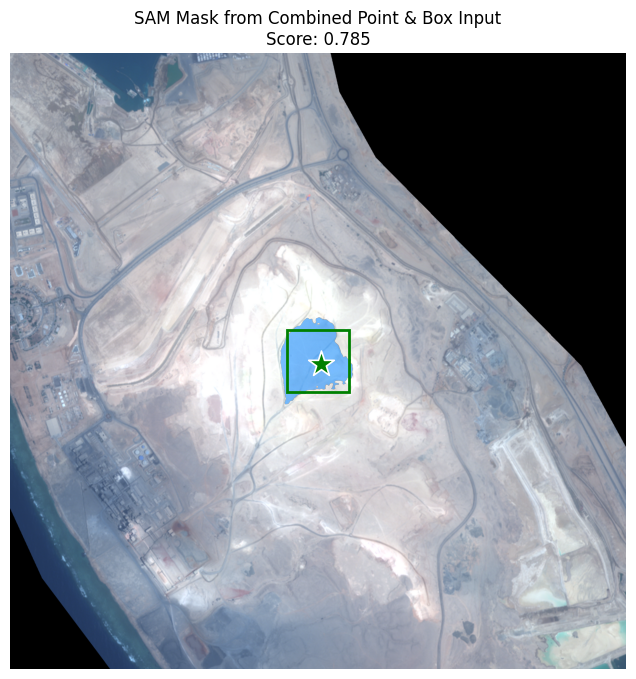


SAM masking examples complete.
Note: SAM is a general segmentation model. To specifically target roads or buildings, you would typically:
1. Provide precise input prompts (points/boxes) on the features you want to segment.
2. Use SAM's output masks as input to further processing or refinement steps.
3. For large areas, you might need to tile the image and run SAM on each tile.
4. Consider using a specialized model fine-tuned for roads if high accuracy is needed.


In [32]:
# prompt: use the sam_vit_h_4b8939.pth model to mask the roads or any thing on the mss  image

import matplotlib.pyplot as plt
import numpy as np
# Install necessary libraries if not already installed
!pip install --upgrade pip
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-contrib-python
!pip install torch torchvision torchaudio

# Check if GPU is available and set device
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Download the SAM model checkpoint if not already present
sam_checkpoint = "sam_vit_h_4b8939.pth"
if not os.path.exists(sam_checkpoint):
    print(f"Downloading SAM model checkpoint: {sam_checkpoint}")
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

# Import SAM
from segment_anything import SamPredictor, sam_model_registry

# Load the SAM model
try:
    sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
    sam.to(device=device)
    predictor = SamPredictor(sam)
    print("SAM model loaded successfully.")
except Exception as e:
    print(f"Error loading SAM model: {e}")
    predictor = None # Set predictor to None if loading fails


def apply_sam_masking(image_data, predictor, input_point=None, input_box=None, input_mask=None):
    """
    Applies SAM (Segment Anything Model) masking to an image.

    Args:
        image_data (np.ndarray): The image data (H, W, C) in RGB format. Must be uint8.
        predictor (SamPredictor): The initialized SAM predictor object.
        input_point (list or np.ndarray): A list of (x, y) point coordinates for SAM.
        input_box (list or np.ndarray): A list of [x1, y1, x2, y2] bounding box coordinates for SAM.
        input_mask (np.ndarray): An initial mask for SAM.

    Returns:
        tuple: (masks, scores, logits) from SAM prediction, or (None, None, None) if predictor is None.
    """
    if predictor is None:
        print("⚠️ SAM predictor not initialized. Cannot apply masking.")
        return None, None, None
    if image_data is None or image_data.size == 0:
        print("⚠️ No image data available for SAM masking.")
        return None, None, None

    print("\n🪄 Applying SAM masking...")
    # SAM expects image data in RGB format with shape (H, W, 3) and type uint8
    if image_data.ndim == 2: # If grayscale, convert to RGB
        image_data_rgb = cv2.cvtColor(image_data, cv2.COLOR_GRAY2RGB)
    elif image_data.ndim == 3 and image_data.shape[-1] == 1: # If single channel, convert to RGB
         image_data_rgb = cv2.cvtColor(image_data.squeeze(), cv2.COLOR_GRAY2RGB)
    elif image_data.ndim == 3 and image_data.shape[-1] == 3: # Already RGB
         image_data_rgb = image_data
    else:
        print(f"⚠️ Unexpected image data shape for SAM: {image_data.shape}")
        return None, None, None

    # Ensure the image is uint8
    if image_data_rgb.dtype != np.uint8:
         image_data_rgb = scale_to_8bit(image_data_rgb) # Use the existing scaling function

    # SAM requires setting the image before predicting
    predictor.set_image(image_data_rgb)

    # Predict masks based on inputs (points, box, or initial mask)
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=np.ones(len(input_point), dtype=int) if input_point is not None else None, # 1 indicates foreground point
        box=input_box,
        mask_input=input_mask,
        multimask_output=False, # Set to False to get a single mask output
    )

    print("✅ SAM masking complete")
    # masks: (N, H, W) boolean masks
    # scores: (N,) confidence scores
    # logits: (N, H, W) raw logits
    return masks, scores, logits

def show_mask(mask, ax, random_color=False):
    """Helper function to display a mask."""
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6]) # Blueish translucent

    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    """Helper function to display input points."""
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.2)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.2)

def show_box(box, ax):
    """Helper function to display a bounding box."""
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


# --- SAM Application ---

# We will use the MSS sample for SAM.
# SAM works best on standard RGB imagery.
# We'll use the True Color composite.
# It's important that the input to SAM is uint8.

if mss_sample is not None and predictor is not None:
    mss_rgb_for_sam = create_rgb_composite(mss_sample, (2, 1, 0)) # Create uint8 RGB

    if mss_rgb_for_sam is not None and mss_rgb_for_sam.size > 0:

        point_y, point_x = 1000, 1000 # y, x
        input_point = np.array([[point_x, point_y]]) # SAM expects (x, y) format
        input_label = np.array([1]) # 1 for foreground

        print("\nAttempting SAM masking using a single point...")
        masks_point, scores_point, logits_point = apply_sam_masking(
            mss_rgb_for_sam,
            predictor,
            input_point=input_point,
            input_box=None,
            input_mask=None
        )

        if masks_point is not None and masks_point.shape[0] > 0:
            print(f"SAM predicted {masks_point.shape[0]} mask(s) from point input.")
            plt.figure(figsize=(8, 8))
            plt.imshow(mss_rgb_for_sam)
            show_mask(masks_point[0], plt.gca())
            show_points(input_point, input_label, plt.gca())
            plt.title(f"SAM Mask from Point Input\nScore: {scores_point[0]:.3f}")
            plt.axis('off')
            plt.show()
        else:
             print("SAM did not return a mask for the point input.")



        box_x_min, box_y_min = 900, 900
        box_x_max, box_y_max = 1100, 1100
        input_box = np.array([box_x_min, box_y_min, box_x_max, box_y_max])

        print("\nAttempting SAM masking using a bounding box...")
        masks_box, scores_box, logits_box = apply_sam_masking(
             mss_rgb_for_sam,
             predictor,
             input_point=None,
             input_box=input_box,
             input_mask=None
         )

        if masks_box is not None and masks_box.shape[0] > 0:
             print(f"SAM predicted {masks_box.shape[0]} mask(s) from box input.")
             plt.figure(figsize=(8, 8))
             plt.imshow(mss_rgb_for_sam)
             show_mask(masks_box[0], plt.gca())
             show_box(input_box, plt.gca())
             plt.title(f"SAM Mask from Box Input\nScore: {scores_box[0]:.3f}")
             plt.axis('off')
             plt.show()
        else:
            print("SAM did not return a mask for the box input.")

        point_y_combo, point_x_combo = 1010, 1010
        input_point_combo = np.array([[point_x_combo, point_y_combo]])
        input_label_combo = np.array([1])

        print("\nAttempting SAM masking using combined point and box...")
        masks_combo, scores_combo, logits_combo = apply_sam_masking(
             mss_rgb_for_sam,
             predictor,
             input_point=input_point_combo,
             input_box=input_box,
             input_mask=None
        )

        if masks_combo is not None and masks_combo.shape[0] > 0:
             print(f"SAM predicted {masks_combo.shape[0]} mask(s) from combined input.")
             plt.figure(figsize=(8, 8))
             plt.imshow(mss_rgb_for_sam)
             show_mask(masks_combo[0], plt.gca())
             show_box(input_box, plt.gca())
             show_points(input_point_combo, input_label_combo, plt.gca())
             plt.title(f"SAM Mask from Combined Point & Box Input\nScore: {scores_combo[0]:.3f}")
             plt.axis('off')
             plt.show()
        else:
            print("SAM did not return a mask for the combined input.")

    else:
        print("❌ MSS RGB composite data not available for SAM.")

else:
    print("❌ SAM predictor not available or MSS sample data is missing. Cannot perform SAM masking.")

